In [1]:
cwk_dir ="drive/MyDrive/NLU Coursework/" #For running in Jack's Google Drive

# Setup

## Connect Google Drive Folder

In [2]:
from google.colab import drive
import os
import sys
drive.mount('/content/drive/')

Mounted at /content/drive/


## Imports

In [40]:
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Add, Layer, LSTM, Bidirectional, Embedding, concatenate, BatchNormalization, SimpleRNN, Attention, GlobalMaxPooling1D, GlobalAveragePooling1D, Conv1D, MaxPooling1D, TimeDistributed, subtract, multiply
from tensorflow.keras.optimizers.legacy import SGD, Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import SparseCategoricalAccuracy as Acc
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy as KAcc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2

import keras
from keras.utils import to_categorical

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import typing
from PIL import Image
import json
from nltk.corpus import stopwords
import gensim.downloader as api
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
import string
from random import randint

In [42]:
from transformers import BertTokenizer, BertModel

In [43]:
#Imports from local libraries
sys.path.append(cwk_dir)
from classes.evaluation import evaluate, draw_confusion_matrix, most_confused_samples
from classes.preprocessing import load_data

In [44]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Primary Variables

Filepath variables

In [35]:
solution_dir = os.path.join(cwk_dir, "solution_B")
models_dir = os.path.join(solution_dir, "models")
results_dir = os.path.join(solution_dir, "results")

Preprocessing variables

In [36]:
LOWER: bool = True
PADDING: str = "post"

nltk.download('stopwords')
# STOP_WORDS = set(stopwords.words('english'))
STOP_WORDS = []

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training variables

In [37]:
# INITIAL_LR: float = 2e-5
INITIAL_LR: float = 0.001

EPOCHS: int = 20
VALIDATION_SPLIT: float = 0.2
BATCH_SIZE: int = 256
DROPOUT: float = 0.3

LOSS_FUNCTION: str = "categorical_crossentropy"
OUTPUT_ACTIVATION: str = "softmax"
NUM_LABELS: int = 2

OPTIMIZER = RMSprop(INITIAL_LR)

Other

In [55]:
MAX_PREMISE_LENGTH: int = None
MAX_HYPOTHESIS_LENGTH: int = None

VOCAB_SIZE: int = None #None is the value to denote that there is no vocab size yet. This is set later, once we have the training data
EMBEDDING_SIZE: int = 300

## Functions

In [12]:
def average_sequence_length(sequence: typing.List[str]) -> int:
  """
  Takes a list of sentences & returns the average length of sentences in that sequence
  """
  lengths = [len(sample) for sample in sequence]
  return int(np.sum(lengths)/len(lengths)) + 1

In [13]:
def show_model_architecture(model: Model, filename: str) -> None:
  """
  Takes a model architecture and will a diagram of the architecture. Saves this diagram also, to the filename specified
  """
  model.summary()
  filename = os.path.join(results_dir, filename)
  plot_model(model, to_file=filename)
  img = Image.open(filename)
  fig, ax = plt.subplots(figsize=(15, 15))
  plt.imshow(img, aspect='equal')

In [14]:
def tokenize_data(tokenizer: Tokenizer, premises: typing.List[str], hypotheses: typing.List[str], maxlen: int = None) ->typing.Tuple[typing.List[str], typing.List[str]]:
  """
  Uses the input tokenizer to tokenizer the premises & hypotheses. Will then pad the sequences correctly, using the maxlen passed in
  """
  premises = tokenizer.texts_to_sequences(premises)
  hypotheses = tokenizer.texts_to_sequences(hypotheses)

  premises = pad_sequences(premises, maxlen=MAX_PREMISE_LENGTH, padding=PADDING)
  hypotheses = pad_sequences(hypotheses, maxlen=MAX_HYPOTHESIS_LENGTH, padding=PADDING)

  return (premises, hypotheses)

In [15]:
def save_keras_model(model: Model, filename: str) -> None:
  """
  Saves the model that's been made
  """
  model.save_weights(os.path.join(models_dir, f"{filename}.hdf5"))
  model_architecture = model.to_json()
  with open(os.path.join(models_dir, f"{filename}.json"), "w") as f:
    f.write(json.dumps(model_architecture, indent=4))

In [16]:
def clean_sentences(sentences: typing.List[str]) -> typing.List[str]:
  """
  Takes a list of sentences & cleans them. Remove stopwords, reduces to lower case, removes punctuation
  """
  sentences = [[word.lower().replace(string.punctuation,"") for word in sentence.split(" ") if word not in STOP_WORDS] for sentence in sentences]
  sentences = [" ".join(sentence) for sentence in sentences]
  return sentences


In [17]:
def plot_history(history, export_path, legend: typing.List[str] = ['train', 'test']):
  """
  Will plot the history of a model, labelling it appropriately
  """
  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')

  plt.savefig(os.path.join(results_dir, export_path))

  plt.show()


# Data Preprocessing

## Load Data

In [18]:
(train_premises, train_hypotheses, train_labels), (dev_premises, dev_hypotheses, dev_labels) = load_data(cwk_dir)

In [19]:
MAX_PREMISE_LENGTH: int = average_sequence_length(sequence=train_premises)
MAX_HYPOTHESIS_LENGTH: int = average_sequence_length(sequence=train_hypotheses)

print(f"MAX_PREMISE_LENGTH: {MAX_PREMISE_LENGTH}")
print(f"MAX_HYPOTHESIS_LENGTH: {MAX_HYPOTHESIS_LENGTH}")

MAX_PREMISE_LENGTH: 110
MAX_HYPOTHESIS_LENGTH: 60


In [45]:
train_labels = to_categorical(train_labels)
dev_labels = to_categorical(dev_labels)

In [21]:
# #Removes stop words, punctuation, reduces to lower case
# train_premises = clean_sentences(sentences=train_premises)
# train_hypotheses = clean_sentences(sentences=train_hypotheses)

# dev_premises = clean_sentences(sentences=dev_premises)
# dev_hypotheses = clean_sentences(sentences=dev_hypotheses)

### Example

In [22]:
index = randint(0, len(train_premises))
print(f"Premise: {train_premises[index]}")
print(f"Hypothesis: {train_hypotheses[index]}")
print(f"Label: {train_labels[index]}")

Premise: The outcome was further territorial gains for Israel with control of the Sinai and the Gaza Strip.
Hypothesis: Israel took no other territories to their borders except for Sinai and the Gaza Strip.
Label: [1.]


## Tokenize Data

In [23]:
tokenizer = Tokenizer(lower=LOWER) #Automatically sets sentence to lower & removes punctuation
tokenizer.fit_on_texts(train_premises + train_hypotheses + dev_premises + dev_hypotheses)

In [24]:
train_premises, train_hypotheses = tokenize_data(tokenizer=tokenizer, premises=train_premises, hypotheses=train_hypotheses)
dev_premises, dev_hypotheses = tokenize_data(tokenizer=tokenizer, premises=dev_premises, hypotheses=dev_hypotheses)

In [59]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 40421


### Example

In [26]:
#Premise
print(f"Sentence: {tokenizer.sequences_to_texts([train_premises[index]])}")
print(f"Tokens: {train_premises[index]}")

Sentence: ['the outcome was further territorial gains for israel with control of the sinai and the gaza strip']
Tokens: [    1  3121    11   764 12178  2937    12  1419    16   338     3     1
  4906     4     1  8342  3451     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


In [27]:
#Hypothesis
print(f"Sentence: {tokenizer.sequences_to_texts([train_hypotheses[index]])}")
print(f"Tokens: {train_hypotheses[index]}")

Sentence: ['israel took no other territories to their borders except for sinai and the gaza strip']
Tokens: [1419  279   40   70 5207    5   42 4438 1181   12 4906    4    1 8342
 3451    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


## Embedding Matrix

In [28]:
### Will use word2vec to create an embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_SIZE))

nltk.download('punkt')
word2vec = api.load('word2vec-google-news-300')

for word, index in tokenizer.word_index.items():
  try:
      embedding_matrix[index, :] = word2vec[word]
  except KeyError:
    pass
print(f"Embeddings shape: {embedding_matrix.shape}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[==================================================] 100.0% 1662.8/1662.8MB downloaded
Embeddings shape: (40421, 300)


# Experiment: Subtraction Sentence Fusion
Inspired by this paper & sentence fusion:
- https://ieeexplore.ieee.org/abstract/document/8029126

There appears to be 3 main ways to fuse sentences:
- Element-wise **subtraction**
- Element-wise **Multiplication**
- The two above but with **reversed** second sentences

Sentence fusion is where the two input sentences, of premises and hypotheses, are combined in different ways. Subtraction will subtract the hidden representations of either sequence. These representations are then passed through a further dense layer before the classifier layer. The 'fusion' layer refers to the dense layer afterwards.

This architecture experiments with just **subtraction**.

In [46]:
model_name = "word2vec_embed"

## Model Architecture

In [47]:
OPTIMIZER = RMSprop(INITIAL_LR)
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.00001, min_delta=0.01)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 300)            1212630   ['input_5[0][0]',             
                                                          0          'input_6[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 1024)                 3330048   ['embedding[0][0]',       

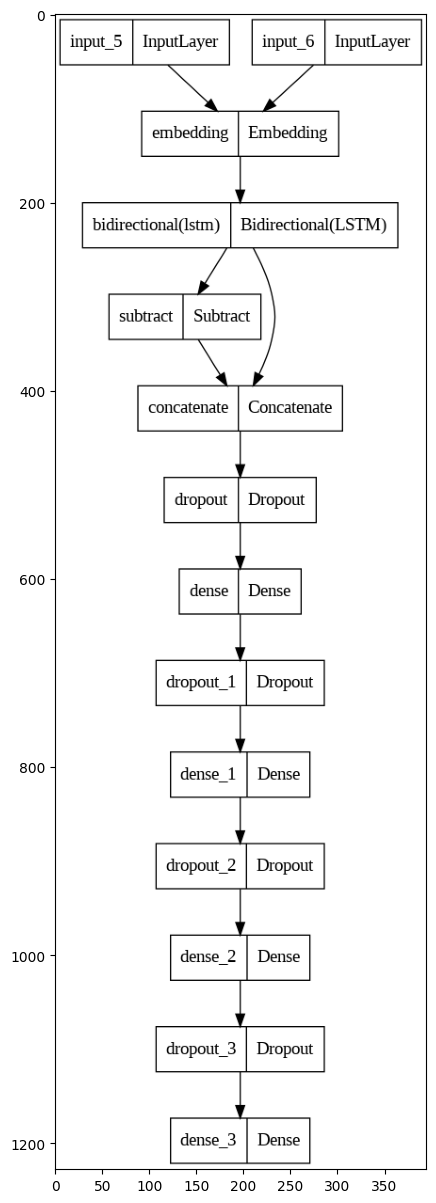

In [60]:
input_premises = Input(shape=(MAX_PREMISE_LENGTH,))
input_hypotheses = Input(shape=(MAX_HYPOTHESIS_LENGTH,))

embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, weights=[embedding_matrix], trainable=True)
premises = embedding_layer(input_premises)
hypotheses = embedding_layer(input_hypotheses)

lstm_layer = Bidirectional(LSTM(512, return_sequences=False, dropout=DROPOUT))
premises = lstm_layer(premises)
hypotheses = lstm_layer(hypotheses)

sub = subtract([premises, hypotheses])
merged = concatenate([premises, sub, hypotheses], axis=-1)

x = Dropout(DROPOUT)(merged)
x = Dense(1024, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(100, activation="relu")(x)
x = Dropout(DROPOUT)(x)
output_layer = Dense(NUM_LABELS, activation=OUTPUT_ACTIVATION)(x)

model = Model(inputs=[input_premises, input_hypotheses], outputs=output_layer)
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=['accuracy'])

show_model_architecture(model=model, filename=f"{model_name}_architecture.png")

## Training

In [61]:
history = model.fit([train_premises, train_hypotheses], train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT, callbacks=[callback])

Epoch 1/20
85/85 [==============================] - 25s 168ms/step - loss: 0.6593 - accuracy: 0.6062 - val_loss: 0.6538 - val_accuracy: 0.6357 - lr: 0.0010
Epoch 2/20
85/85 [==============================] - 12s 146ms/step - loss: 0.5895 - accuracy: 0.6866 - val_loss: 0.5950 - val_accuracy: 0.6736 - lr: 0.0010
Epoch 3/20
85/85 [==============================] - 12s 145ms/step - loss: 0.6396 - accuracy: 0.7092 - val_loss: 0.5918 - val_accuracy: 0.6716 - lr: 0.0010
Epoch 4/20
85/85 [==============================] - 13s 151ms/step - loss: 0.4996 - accuracy: 0.7570 - val_loss: 0.7698 - val_accuracy: 0.6389 - lr: 0.0010
Epoch 5/20
85/85 [==============================] - 12s 146ms/step - loss: 0.4250 - accuracy: 0.8023 - val_loss: 0.6283 - val_accuracy: 0.6745 - lr: 5.0000e-04
Epoch 6/20
85/85 [==============================] - 13s 150ms/step - loss: 0.3849 - accuracy: 0.8264 - val_loss: 0.6130 - val_accuracy: 0.6777 - lr: 5.0000e-04
Epoch 7/20
85/85 [==============================] - 12s 

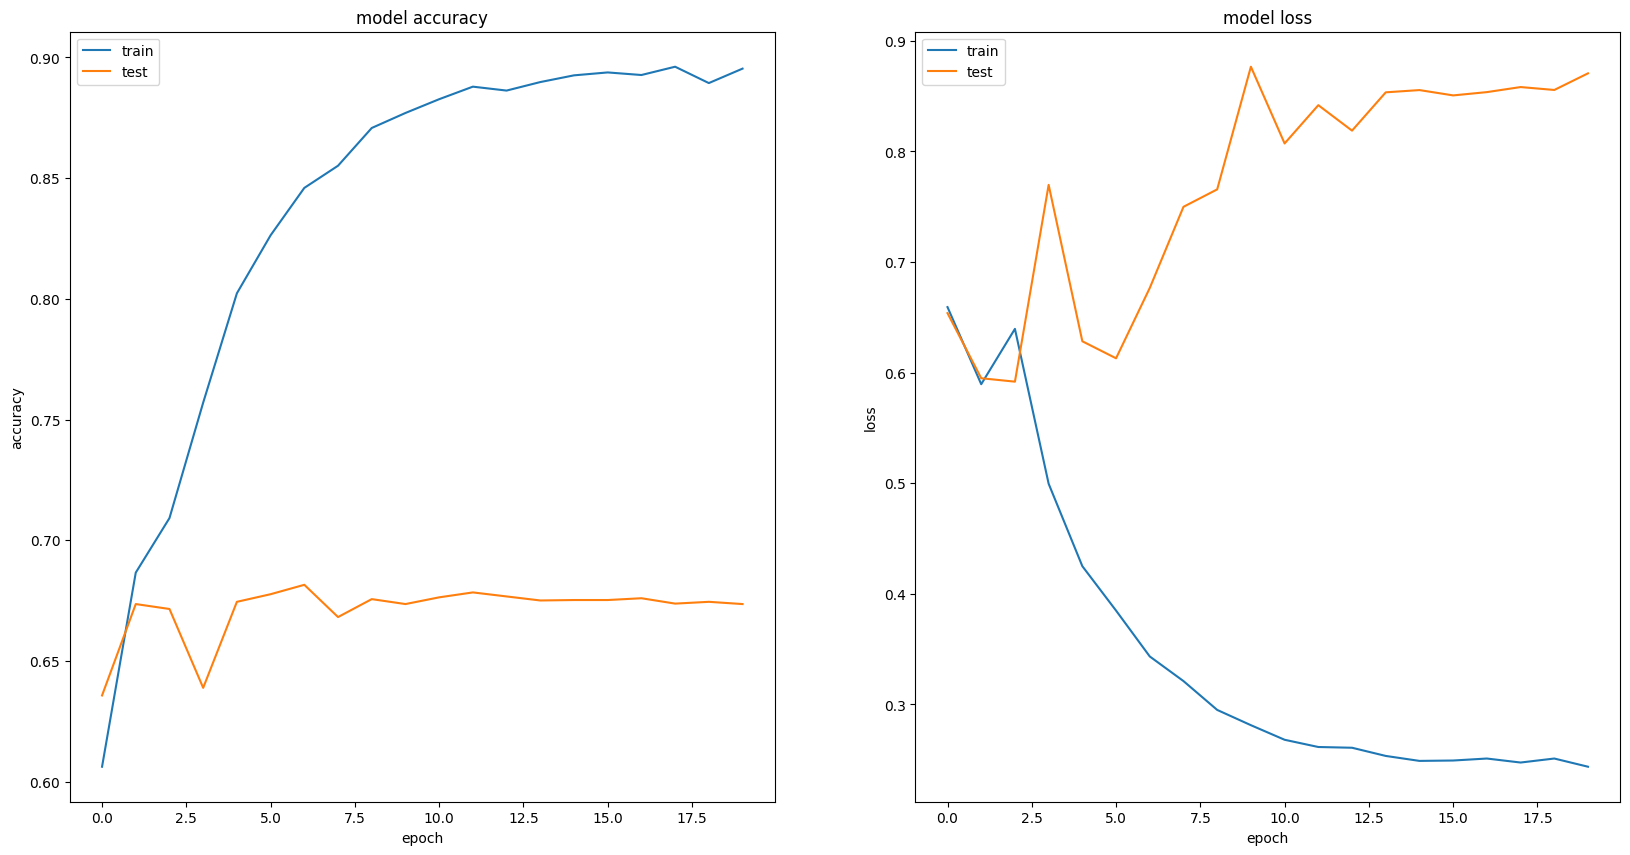

In [62]:
#Plot model
plot_history(history=history, export_path=f"{model_name}_history.pdf")

In [63]:
#Save the model
save_keras_model(model=model, filename=model_name)

## Evaluate

In [64]:
predicted_logits = model.predict(x=[dev_premises, dev_hypotheses])
true_labels=np.argmax(dev_labels, axis=1)

#Evaluation Metrics
test_metrics = evaluate(true_labels=true_labels, predicted_logits=np.array(predicted_logits))
test_metrics.to_csv(os.path.join(results_dir, f"{model_name}_metrics.csv"), index=False)
test_metrics.head()

211/211 [==============================] - 4s 13ms/step


,Accuracy,Precision,Macro Precision,Weighted Macro Precision,Recall,Macro Recall,Weighted Macro Recall,F1-Score,Macro F1-Score,Weighted Macro F1-Score,MCC,Loss
0,0.673594,0.695386,0.674194,0.674883,0.654399,0.674239,0.673594,0.67427,0.673592,0.673614,0.348433,0.829752


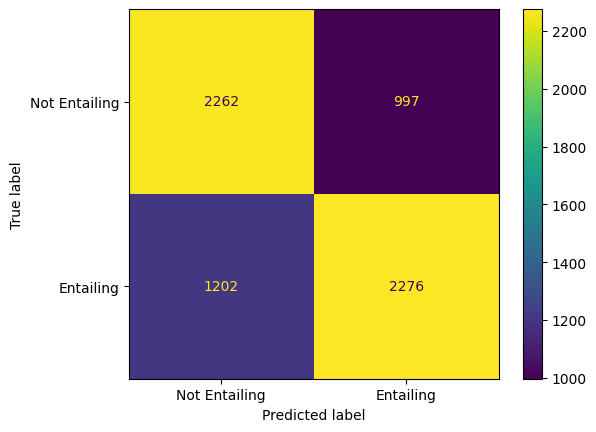

In [65]:
conf_mat = draw_confusion_matrix(true_labels=true_labels, predicted_logits=np.array(predicted_logits))

In [66]:
df = most_confused_samples(true_logits=dev_labels, predicted_logits=np.array(predicted_logits), premises=dev_premises_og, hypotheses=dev_hypotheses_og, num=10)
df

NameError: name 'dev_premises_og' is not defined